# Calculate low-rank dynamic FC and use it to approximate static FC
We can approximate static FC with \~120 rank-\~120 dictionary entries<br>
We can also approximate dynamic FC with >300 rank-1 dictionary entries<br>
Can the rank-1 entries sum together to approximate a static FC?

In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age', 'sex', 'wrat'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

830
(830, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.2], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [np.stack([ts for ts in filter_design_ts(Xp)]) for Xp in X]
ts = [tsmod/np.linalg.norm(tsmod, axis=(-1), keepdims=True) for tsmod in ts]
print(ts[0].shape)

(830, 264, 124)


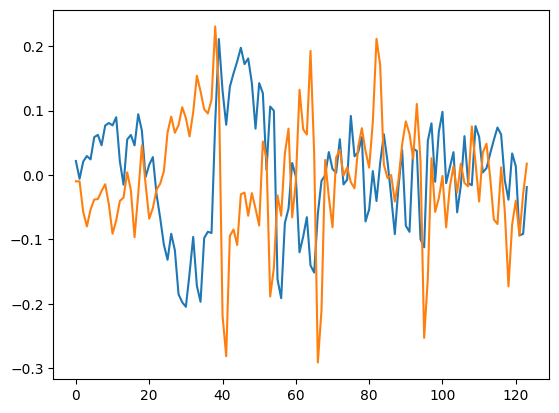

In [4]:
import matplotlib.pyplot as plt

plt.plot(ts[0][1,0])
plt.plot(ts[0][1,100])
plt.show()

In [516]:
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

class LowRankCodes(nn.Module):
    '''
    ranks: array of rank for each codebook matrix
    '''
    def __init__(self, ranks):
        super(LowRankCodes, self).__init__()
        self.As = []
        for rank in ranks:
            A = nn.Parameter(1e-2*torch.randn(rank,264).float().cuda())
            self.As.append(A)
        self.As = nn.ParameterList(self.As)

    def forward(self):
        book = []
        for A in self.As:
            AA = A.T@A
            book.append(AA)
        return torch.stack(book)
    
class LowRankWeights(nn.Module):
    '''
    For a single modality!
    
    nsubs: number of subjects
    ncodes: number of pages in the codebook
    nt: number of timepoints
    '''
    def __init__(self, nsubs, ncodes, nt):
        super(LowRankWeights, self).__init__()
        self.w = nn.Parameter(1e-2*torch.rand(nsubs, ncodes, nt).float().cuda())

    def forward(self, sub, book):
        w = self.w[sub]
        return torch.einsum('pt,pab->abt', w, book)
    
def get_recon_loss(x, xhat):
    return mseLoss(xhat, x)

def get_smooth_loss_fc(xhat):
    before = xhat[:,:,:-1]
    after = xhat[:,:,1:]
    return torch.mean((before-after)**2)

def get_sub_fc(subts):
    return torch.einsum('at,bt->abt',subts,subts)
    
# Timeseries
x = torch.from_numpy(ts[2]).float().cuda()
    
# Parameters
ntrain = 400
nbatch = 30
smooth_mult = 0.1
sparse_mult = 0#1e-3
nEpochs = 50
pPeriod = 40

mseLoss = nn.MSELoss()
    
# Codebook and weights
lrc = LowRankCodes(800*[1])
ncodes = len(lrc.As)

lrw = LowRankWeights(ntrain, ncodes, x.shape[-1])

# Optimizers
optim = torch.optim.Adam(itertools.chain(lrc.parameters(), lrw.parameters()), lr=1e-2, weight_decay=0)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=int(ntrain/nbatch)+5, factor=0.75, eps=1e-7)
    
for epoch in range(nEpochs):
    suborder = np.arange(ntrain)
#     np.random.shuffle(suborder)
    for bstart in range(0,ntrain,nbatch):
        bend = bstart+nbatch
        if bend > ntrain:
            bend = ntrain
        optim.zero_grad()
        book = lrc()
        recon_loss = 0
        smooth_loss_fc = 0
        for subidx in range(bstart, bend):
            sub = suborder[subidx]
            xsub = get_sub_fc(x[sub])
            xhat = lrw(sub, book)
            recon_loss += get_recon_loss(xsub, xhat)
            smooth_loss_fc += smooth_mult*get_smooth_loss_fc(xhat)
        recon_loss /= (bend-bstart)
        smooth_loss_fc /= (bend-bstart)
        sparse_loss = sparse_mult*torch.mean(torch.abs(lrw.w))
#         sparse_loss = sparse_mult*torch.mean(lrw.w*torch.log(lrw.w))
        totloss = recon_loss+smooth_loss_fc+sparse_loss
        totloss.backward()
        optim.step()
        sched.step(totloss)
        if bstart % nbatch == 0:
            print(f'{epoch} {bstart} recon: {[float(ls)**0.5 for ls in [recon_loss, smooth_loss_fc, sparse_loss]]} '
                  f'lr: {sched._last_lr}')

print('Complete')

0 0 recon: [0.007254330916025339, 3.6699952196521177e-06, 0.0] lr: [0.01]
0 30 recon: [0.008285328825906184, 3.678888031699235e-06, 0.0] lr: [0.01]
0 60 recon: [0.007747000953976819, 3.6863476927320634e-06, 0.0] lr: [0.01]
0 90 recon: [0.007479219144743844, 3.6988903844100623e-06, 0.0] lr: [0.01]
0 120 recon: [0.008325283792590479, 3.709124132270325e-06, 0.0] lr: [0.01]
0 150 recon: [0.008356992694602291, 3.720857242914841e-06, 0.0] lr: [0.01]
0 180 recon: [0.008600705993234996, 3.7313271294932826e-06, 0.0] lr: [0.01]
0 210 recon: [0.007584266711620383, 3.74988762772505e-06, 0.0] lr: [0.01]
0 240 recon: [0.007597482938325073, 3.7649621336365547e-06, 0.0] lr: [0.01]
0 270 recon: [0.008245534100203624, 3.781844113483098e-06, 0.0] lr: [0.01]
0 300 recon: [0.007387646817481829, 3.800606474097472e-06, 0.0] lr: [0.01]
0 330 recon: [0.008747494684960605, 3.822561518049853e-06, 0.0] lr: [0.01]
0 360 recon: [0.007251259388047747, 3.850332173722191e-06, 0.0] lr: [0.01]
0 390 recon: [0.0070670139

7 360 recon: [0.006175639959343383, 0.0008351117080623049, 0.0] lr: [0.0075]
7 390 recon: [0.006787778404163329, 0.0015329048703667948, 0.0] lr: [0.0075]
8 0 recon: [0.0062276080765009964, 0.0008024903396147274, 0.0] lr: [0.0075]
8 30 recon: [0.006619403898281622, 0.001206909465180271, 0.0] lr: [0.0075]
8 60 recon: [0.006244617478329413, 0.0011023101424067264, 0.0] lr: [0.0075]
8 90 recon: [0.0064227007831097515, 0.0009191486765682794, 0.0] lr: [0.0075]
8 120 recon: [0.006826025831825476, 0.001086494470920207, 0.0] lr: [0.0075]
8 150 recon: [0.006561473910084766, 0.0013579257376849212, 0.0] lr: [0.0075]
8 180 recon: [0.006382571648078611, 0.00143713269133519, 0.0] lr: [0.0075]
8 210 recon: [0.006379768694650832, 0.0010755141117784108, 0.0] lr: [0.0075]
8 240 recon: [0.006467065173793113, 0.0010676944597832153, 0.0] lr: [0.0075]
8 270 recon: [0.006640405708261446, 0.0013200926479946904, 0.0] lr: [0.0075]
8 300 recon: [0.00614563091093186, 0.0010489136444249685, 0.0] lr: [0.0075]
8 330 r

15 210 recon: [0.005932944587025045, 0.001155826370395181, 0.0] lr: [0.0075]
15 240 recon: [0.006089473306456165, 0.0011294952796982636, 0.0] lr: [0.0075]
15 270 recon: [0.0062433601477189975, 0.0014126065610384248, 0.0] lr: [0.0075]
15 300 recon: [0.005828061286620996, 0.0011865325473328495, 0.0] lr: [0.0075]
15 330 recon: [0.006116149462960898, 0.0016838859996491722, 0.0] lr: [0.0075]
15 360 recon: [0.005802817874186992, 0.0010825253217269497, 0.0] lr: [0.0075]
15 390 recon: [0.005523119978248001, 0.0011066609724482233, 0.0] lr: [0.0075]
16 0 recon: [0.005779433169333829, 0.0010693243646274439, 0.0] lr: [0.0075]
16 30 recon: [0.006120988155219801, 0.0015028496466666435, 0.0] lr: [0.0075]
16 60 recon: [0.005744648795877695, 0.0013952964945882762, 0.0] lr: [0.0075]
16 90 recon: [0.005906323937502497, 0.0011425591953536617, 0.0] lr: [0.0075]
16 120 recon: [0.006399200143666678, 0.001269218344365636, 0.0] lr: [0.0075]
16 150 recon: [0.005998226935794187, 0.0015511723835608627, 0.0] lr: [

22 360 recon: [0.005526162415029903, 0.0012033301952643332, 0.0] lr: [0.0031640625]
22 390 recon: [0.005195670365669961, 0.0012851500091837823, 0.0] lr: [0.0031640625]
23 0 recon: [0.005486026239188848, 0.0011959009383288722, 0.0] lr: [0.0031640625]
23 30 recon: [0.005795461793679614, 0.0016164751531075724, 0.0] lr: [0.0031640625]
23 60 recon: [0.005489488537623338, 0.0014833542563656933, 0.0] lr: [0.0031640625]
23 90 recon: [0.005599482486021979, 0.0012669846844183153, 0.0] lr: [0.0031640625]
23 120 recon: [0.006109293051047943, 0.0013666874596309265, 0.0] lr: [0.0031640625]
23 150 recon: [0.005673940626882235, 0.001660907057659576, 0.0] lr: [0.0031640625]
23 180 recon: [0.005525694659443666, 0.0017435124087034394, 0.0] lr: [0.0031640625]
23 210 recon: [0.005576666973981772, 0.0013053356022451883, 0.0] lr: [0.0031640625]
23 240 recon: [0.005763155762540504, 0.001276710721122136, 0.0] lr: [0.0031640625]
23 270 recon: [0.005833572707371982, 0.0015510083498280229, 0.0] lr: [0.0031640625]

29 390 recon: [0.0050695263552970925, 0.0013320116355139144, 0.0] lr: [0.0031640625]
30 0 recon: [0.005343704159093239, 0.0012612274779080265, 0.0] lr: [0.0031640625]
30 30 recon: [0.00563425556073357, 0.0016735429365525923, 0.0] lr: [0.0031640625]
30 60 recon: [0.005355218331522639, 0.001528370358039816, 0.0] lr: [0.0031640625]
30 90 recon: [0.005444234916044851, 0.001331396591365519, 0.0] lr: [0.0031640625]
30 120 recon: [0.005943826877171754, 0.001423822819369328, 0.0] lr: [0.0031640625]
30 150 recon: [0.005517917234678155, 0.0017154940953718323, 0.0] lr: [0.0031640625]
30 180 recon: [0.00536778060641041, 0.0017888615103599165, 0.0] lr: [0.0031640625]
30 210 recon: [0.0054488101739507905, 0.001355554783444945, 0.0] lr: [0.0031640625]
30 240 recon: [0.005622441587812534, 0.0013346976998713758, 0.0] lr: [0.0031640625]
30 270 recon: [0.005654259985369417, 0.0016117302622401073, 0.0] lr: [0.0031640625]
30 300 recon: [0.005306406896186953, 0.0013721271971002462, 0.0] lr: [0.0031640625]
3

36 210 recon: [0.005382659161861088, 0.001377780145184594, 0.0] lr: [0.0017797851562500002]
36 240 recon: [0.00555596840893267, 0.0013605608514134213, 0.0] lr: [0.0017797851562500002]
36 270 recon: [0.0055686963226781044, 0.0016411331566717504, 0.0] lr: [0.0017797851562500002]
36 300 recon: [0.005223617678235866, 0.0013998524298121145, 0.0] lr: [0.0017797851562500002]
36 330 recon: [0.00546041884767124, 0.0019047882657466056, 0.0] lr: [0.0017797851562500002]
36 360 recon: [0.0053281781497188496, 0.00129417338208492, 0.0] lr: [0.0017797851562500002]
36 390 recon: [0.00499656905518607, 0.0013377237092100727, 0.0] lr: [0.0017797851562500002]
37 0 recon: [0.005261212469776016, 0.00129420210712585, 0.0] lr: [0.0017797851562500002]
37 30 recon: [0.005544541419629847, 0.0017024434193926954, 0.0] lr: [0.0017797851562500002]
37 60 recon: [0.00527858260308719, 0.00155190153004829, 0.0] lr: [0.0017797851562500002]
37 90 recon: [0.005359862788296705, 0.0013659747593185705, 0.0] lr: [0.001779785156

42 360 recon: [0.00528539384165937, 0.0013119075418217313, 0.0] lr: [0.0017797851562500002]
42 390 recon: [0.004954206540194675, 0.0013490154694998108, 0.0] lr: [0.0017797851562500002]
43 0 recon: [0.0052084517457721205, 0.001314662356182137, 0.0] lr: [0.0017797851562500002]
43 30 recon: [0.005488370419733246, 0.0017199478619996662, 0.0] lr: [0.0017797851562500002]
43 60 recon: [0.005230900582770799, 0.0015665447635884889, 0.0] lr: [0.0017797851562500002]
43 90 recon: [0.005307913249550865, 0.0013870131523146167, 0.0] lr: [0.0017797851562500002]
43 120 recon: [0.005792030239358097, 0.0014760835238821427, 0.0] lr: [0.0017797851562500002]
43 150 recon: [0.005381490793454077, 0.0017594450514440171, 0.0] lr: [0.0017797851562500002]
43 180 recon: [0.005225331356006695, 0.0018295020111633298, 0.0] lr: [0.0017797851562500002]
43 210 recon: [0.00532270233414339, 0.0013972026071949828, 0.0] lr: [0.0017797851562500002]
43 240 recon: [0.005497653107110641, 0.0013827526960060147, 0.0] lr: [0.00177

49 90 recon: [0.005260870698855451, 0.0014053148275787442, 0.0] lr: [0.0017797851562500002]
49 120 recon: [0.005735370698086133, 0.0014944078059582855, 0.0] lr: [0.0017797851562500002]
49 150 recon: [0.005331809819059289, 0.0017740723106620807, 0.0] lr: [0.0017797851562500002]
49 180 recon: [0.005173417449315532, 0.0018433792491454588, 0.0] lr: [0.0017797851562500002]
49 210 recon: [0.005274960496088972, 0.0014125380707403971, 0.0] lr: [0.0017797851562500002]
49 240 recon: [0.005451658355297897, 0.0013997232944789216, 0.0] lr: [0.0017797851562500002]
49 270 recon: [0.005435263273263552, 0.0016864931493711058, 0.0] lr: [0.0017797851562500002]
49 300 recon: [0.0050951435327337745, 0.0014441559480350794, 0.0] lr: [0.0017797851562500002]
49 330 recon: [0.0053228747400444875, 0.0019405428754327937, 0.0] lr: [0.0017797851562500002]
49 360 recon: [0.0052400987182266165, 0.0013298752400687601, 0.0] lr: [0.0017797851562500002]
49 390 recon: [0.004906984749987567, 0.0013629471617971278, 0.0] lr:

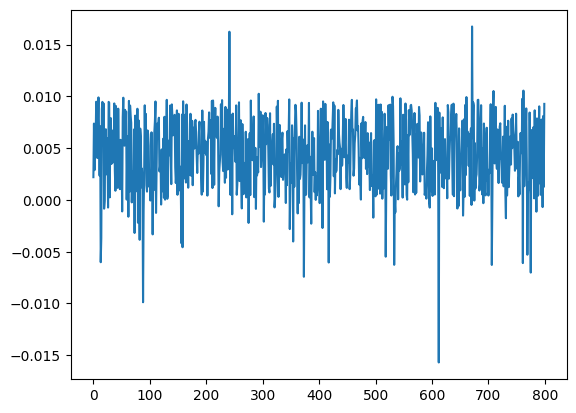

In [517]:
import matplotlib.pyplot as plt

plt.plot(lrw.w[3,:,10].detach().cpu().numpy())
plt.show()

In [233]:
# Elastic net attempt
# Keep the Lagrangian form of lstsqs to reduce data size

class ElasticNet(nn.Module):
    def __init__(self, AA, AB, l1, l2):
        super(ElasticNet, self).__init__()
        self.AA = AA
        self.AB = AB
        self.w = nn.Parameter(torch.rand(AB.shape[0],AA.shape[1],AB.shape[-1]).float().cuda())
        self.l1 = l1
        self.l2 = l2
        
    def train(self, lr=1e-1, nepochs=2000, pperiod=100, verbose=True):
        mseLoss = nn.MSELoss()
        optim = torch.optim.Adam([self.w], lr=lr, weight_decay=self.l2)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.75, eps=1e-7)
        for epoch in range(nepochs):
            optim.zero_grad()
            ABhat = torch.matmul(self.AA.detach(),self.w)
            loss = mseLoss(ABhat, self.AB.detach())**0.5
            l1loss = self.l1*torch.mean(torch.abs(self.w))
            totloss = loss+l1loss
            totloss.backward()
            optim.step()
            sched.step(totloss)
            if not verbose:
                continue
            if epoch % pperiod == 0 or epoch == nepochs-1:
                print(f'{epoch} {[float(ls) for ls in [loss, l1loss]]} {sched._last_lr}')
        if verbose:
            print('Complete')

book = lrc()

A = book.reshape(book.shape[0], -1).permute(1,0).detach()
AA = A.T@A
AB = []

for sub in range(x.shape[0]):
    B = get_sub_fc(x[sub]).reshape(-1, x.shape[-1])
    AB.append(A.T@B)

AB = torch.stack(AB)
net = ElasticNet(AA.unsqueeze(0), AB, 0, 1e-5)
net.train(nepochs=500, lr=1e-1)

KeyboardInterrupt: 

In [518]:
# Fast weight estimation for all subjects

book = lrc()

A = book.reshape(book.shape[0], -1).permute(1,0)
AA = A.T@A
codes = []

for sub in range(x.shape[0]):
    B = get_sub_fc(x[sub]).reshape(-1, x.shape[-1])
    AB = A.T@B
    C,_,_,_ = torch.linalg.lstsq(AA+1*torch.eye(AA.shape[0]).float().cuda(),AB)
    codes.append(torch.from_numpy(C.detach().cpu().numpy()))
    if sub % 100 == 0:
        loss = mseLoss(A@C,B)**0.5
        print(f'Finished {sub} {loss}')
    
codes = torch.stack(codes)
print(codes.shape)

Finished 0 0.004173534922301769
Finished 100 0.006023578345775604
Finished 200 0.0042414008639752865
Finished 300 0.004760374315083027
Finished 400 0.006790948566049337
Finished 500 0.004810036160051823
Finished 600 0.004509931430220604
Finished 700 0.004826804157346487
Finished 800 0.0039308806881308556
torch.Size([830, 800, 210])


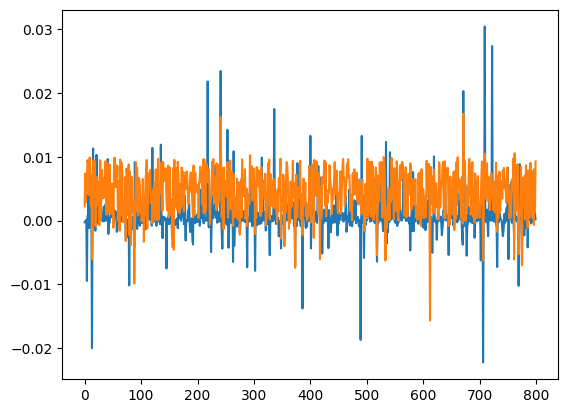

In [519]:
import matplotlib.pyplot as plt

plt.plot(codes[3,:,10].detach().cpu().numpy())
# plt.plot(net.w[3,:,10].detach().cpu().numpy(), linewidth='3')
plt.plot(lrw.w[3,:,10].detach().cpu().numpy())
plt.show()

0.2762320580818671
0.2839450584928121
0.28442920850106623


/tmp/ipykernel_50363/3489957738.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


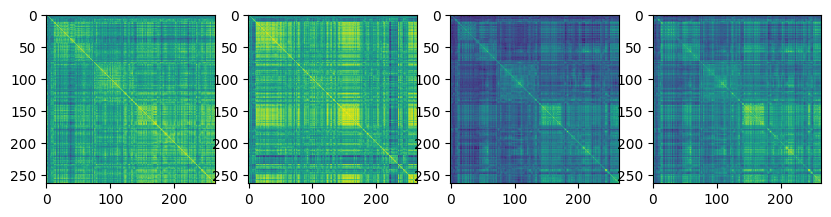

In [521]:
# Reconstruct static FC from dynamic FC

import matplotlib.pyplot as plt

sub = 204

dynfc = get_sub_fc(x[sub])
dynfc = torch.mean(dynfc, dim=-1).detach().cpu().numpy()

statfc = np.corrcoef(ts[0][sub])

reconfc = lrw(sub, book)
reconfc = torch.mean(reconfc, dim=-1).detach().cpu().numpy()

A = book.reshape(book.shape[0], -1).permute(1,0)
reconfc2 = torch.mean(A.cpu()@codes[sub].cpu(), dim=1).reshape(264,264).detach().cpu().numpy()

fig, ax = plt.subplots(1,4,figsize=(10,3))

print(np.mean((statfc-124*dynfc)**2)**0.5)
print(np.mean((statfc-124*reconfc)**2)**0.5)
print(np.mean((statfc-124*reconfc2)**2)**0.5)

ax[0].imshow(dynfc)
ax[1].imshow(statfc)
ax[2].imshow(reconfc)
ax[3].imshow(reconfc2)
fig.show()

In [548]:
ntrain = 30

losses = []


idcs = np.arange(net.w.shape[0])
np.random.shuffle(idcs)

for ntrain in [30,50,100,200,300,400,500,600,700,800]:

    codescuda = codes.float().cuda()
#     codescuda = net.w.detach()
    xps = torch.mean(codescuda, dim=-1) #ps.reshape(ps.shape[0],-1)
    xps = torch.cat([xps, torch.ones(xps.shape[0], 1).float().cuda()], dim=1)
    xtr = xps[idcs[:ntrain]]
    xt = xps[idcs[ntrain:]]
#     xtr, xt = xt, xtr

    y = get_y(metadict, ['wrat'], subs)[0]
    y_t = torch.from_numpy(y).float().cuda()
    ytr = y_t[idcs[:ntrain]]
    yt = y_t[idcs[ntrain:]]
#     ytr, yt = yt, ytr

    # REDUCE THIS TO GET GOOD RESULTS WITH SPARSITY 0.01->0.001 or 0.0001
    w, _, _, _ = torch.linalg.lstsq(xtr.T@xtr + 0.001*torch.eye(801).float().cuda(), xtr.T@ytr)

#     print(torch.mean((ytr-xtr@w)**2)**0.5)
    losses.append(float(torch.mean((yt-xt@w)**2)**0.5))
    
print(losses)

[16.027584075927734, 15.733467102050781, 15.818231582641602, 15.831223487854004, 16.105073928833008, 15.689632415771484, 15.779061317443848, 14.729107856750488, 15.073945999145508, 13.87969970703125]


In [582]:
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
    
class CNN(nn.Module):
    def __init__(self, x, dp=0.1):
        super(CNN, self).__init__()
        self.cnn1 = torch.nn.Conv2d(1,10,(x.shape[-2],4)).float().cuda()
        self.ap1 = torch.nn.AvgPool2d((1,x.shape[-1]-3))
        self.lin1 = torch.nn.Linear(10,1).float().cuda()
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, ts):
        ts = self.dp(ts)
        y = F.relu(self.cnn1(ts))
        y = self.ap1(y)
        z = y.reshape(y.shape[0], -1).squeeze()
        y = self.lin1(z)
        return z, y.squeeze()
    
nEpochs = 1000
pPeriod = 200

ntrain = 30

losses = []

for ntrain in [30,50,100,200,300,400,500,600,700,800]:

#     codescuda = F.relu(net.w.detach()) 
    codescuda = codes.float().cuda()
    xps = codescuda.unsqueeze(1)
    xtr = xps[:ntrain]
    xt = xps[ntrain:]

    y = get_y(metadict, ['age'], subs)[0]
    y_t = torch.from_numpy(y).float().cuda()
    ytr = y_t[:ntrain]
    yt = y_t[ntrain:]

    cnn = CNN(xtr, dp=0)

    optim = torch.optim.Adam(cnn.parameters(), lr=1e-1, weight_decay=1e-1)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.9, eps=1e-7)

    for epoch in range(nEpochs):
        optim.zero_grad()
        z, yhat1 = cnn(xtr)
        loss = mseLoss(yhat1, ytr)
        loss.backward()
        optim.step()
        sched.step(loss)
        if epoch % pPeriod == 0 or epoch == nEpochs-1:
            print(f'{epoch} recon: {loss**0.5} {sched._last_lr}')

    print('Complete')

    cnn.eval()
    z, yhat1 = cnn(xt)
    loss = mseLoss(yhat1, yt)**0.5
    losses.append(float(loss))
    
    print(loss)
    
print(losses)

0 recon: 191.0916748046875 [0.1]
200 recon: 15.736668586730957 [0.09000000000000001]
400 recon: 11.911853790283203 [0.09000000000000001]
600 recon: 9.101534843444824 [0.09000000000000001]
800 recon: 7.261926651000977 [0.09000000000000001]
999 recon: 6.089686393737793 [0.09000000000000001]
Complete
tensor(38.3825, device='cuda:0', grad_fn=<PowBackward0>)
0 recon: 187.76272583007812 [0.1]
200 recon: 19.286340713500977 [0.08100000000000002]
400 recon: 17.09270477294922 [0.08100000000000002]


KeyboardInterrupt: 

In [19]:
import sys

sys.path.append('../../LatentSimilarity')

from latsim import LatSim

print('Complete')

Complete


In [79]:
ntrain = 800

losses = []

for ntrain in [30,50,100,200,300,400,500,600,700,800]:
    codescuda = codes.float().cuda()
    xps = codescuda.unsqueeze(1)
    xtr = xps[:ntrain]
    xt = xps[ntrain:]

    y = get_y(metadict, ['age'], subs)[0]
    y_t = torch.from_numpy(y).float().cuda()
    ytr = y_t[:ntrain]
    yt = y_t[ntrain:]

    mseLoss = nn.MSELoss()

    nEpochs = 500
    pPeriod = 100

    cnn = CNN(xtr, dp=0.1)
    sim = LatSim(1, torch.zeros(1,1,10), dp=0, edp=0.1, wInit=1e-4, dim=20, temp=1)

    optim = torch.optim.Adam(itertools.chain(cnn.parameters(), sim.parameters()), lr=1e-1, weight_decay=1e-2)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.9, eps=1e-7)

    for epoch in range(nEpochs):
        optim.zero_grad()
        z, yhat1 = cnn(xtr)
        yhat2 = sim(z.unsqueeze(1), [ytr])[0][0]
        loss = mseLoss(yhat2, ytr)
        loss.backward()
        optim.step()
        sched.step(loss)
        if epoch % pPeriod == 0 or epoch == nEpochs-1:
            print(f'{epoch} recon: {loss**0.5} {sched._last_lr}')

    print('Complete')

    cnn.eval()
    sim.eval()
    z, yhat1 = cnn(xps)
    yhat2 = sim(z.unsqueeze(1), [y_t])[0][0][ntrain:]
    loss = mseLoss(yhat2, yt)**0.5
    losses.append(float(loss))
    
    print(float(loss))
    
print(losses)

0 recon: 39.34846878051758 [0.1]
100 recon: 6.653782367706299 [0.07290000000000002]
200 recon: 5.5418782234191895 [0.03138105960900001]
300 recon: 6.603857517242432 [0.01215766545905694]
400 recon: 5.476126194000244 [0.00471012869724625]
499 recon: 6.494833946228027 [0.0018248003631400759]
Complete
38.64051818847656
0 recon: 35.32155227661133 [0.1]
100 recon: 5.833658218383789 [0.1]
200 recon: 3.452425718307495 [0.04782969000000002]
300 recon: 3.4900293350219727 [0.01853020188851842]
400 recon: 3.4938457012176514 [0.009847709021836121]
499 recon: 2.936023712158203 [0.004239115827521626]
Complete
37.8840217590332
0 recon: 37.065433502197266 [0.1]
100 recon: 4.202347278594971 [0.09000000000000001]
200 recon: 4.340254783630371 [0.04782969000000002]
300 recon: 3.6471965312957764 [0.01853020188851842]
400 recon: 3.6380465030670166 [0.00886293811965251]
499 recon: 3.522996425628662 [0.003433683820292517]
Complete
37.18783950805664
0 recon: 39.9236946105957 [0.1]
100 recon: 5.171610355377197 

In [550]:
ntrain = 700

losses = []

idcs = np.arange(net.w.shape[0])
np.random.shuffle(idcs)

for ntrain in [30,50,100,200,300,400,500,600,700,800]:
    codescuda = codes.float().cuda()
#     codescuda = F.relu(net.w.detach())
    xps = torch.mean(codescuda[idcs], dim=-1).unsqueeze(1)
    
    mu = torch.mean(xps, dim=0, keepdims=True)
    std = torch.std(xps, dim=0, keepdims=True)
    xps = (xps-mu)/std
    
    xtr = xps[:ntrain]
    xt = xps[ntrain:]

    y = get_y(metadict, ['wrat'], subs)[0]
    
    y_t = torch.from_numpy(y[idcs]).float().cuda()
    
#     mu = torch.mean(y_t, dim=0, keepdims=True)
#     std = torch.std(y_t, dim=0, keepdims=True)
#     y_t = (y_t-mu)/std
    
    ytr = y_t[:ntrain]
    yt = y_t[ntrain:]

    mseLoss = nn.MSELoss()

    nEpochs = 500
    pPeriod = 100

    sim = LatSim(1, torch.zeros(1,1,ncodes), dp=0.5, edp=0.1, wInit=1e-4, dim=2, temp=10)

    optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-3)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.9, eps=1e-7)

    for epoch in range(nEpochs):
        optim.zero_grad()
        yhat = sim(xtr, [ytr])[0][0]
        loss = mseLoss(yhat, ytr)
        loss.backward()
        optim.step()
        sched.step(loss)
        if epoch % pPeriod == 0 or epoch == nEpochs-1:
            print(f'{epoch} recon: {loss**0.5} {sched._last_lr}')

    print('Complete')

    sim.eval()
    yhat = sim(xps, [y_t], np.arange(ntrain,idcs.shape[0]))[0][0][ntrain:]
    loss = mseLoss(yhat, yt)**0.5
    losses.append(float(loss))
    
    print(loss)
print(losses)

0 recon: 14.415180206298828 [0.0001]
100 recon: 13.577707290649414 [7.290000000000001e-05]
200 recon: 11.234376907348633 [5.904900000000002e-05]
300 recon: 9.567015647888184 [3.4867844010000016e-05]
400 recon: 9.202320098876953 [1.5009463529699922e-05]
499 recon: 8.62769889831543 [7.1789798769185315e-06]
Complete
tensor(16.5268, device='cuda:0', grad_fn=<PowBackward0>)
0 recon: 13.7506742477417 [0.0001]
100 recon: 12.396267890930176 [8.1e-05]
200 recon: 11.412762641906738 [5.904900000000002e-05]
300 recon: 10.841997146606445 [3.138105960900002e-05]
400 recon: 10.387980461120605 [1.5009463529699922e-05]
499 recon: 10.093481063842773 [6.461081889226678e-06]
Complete
tensor(16.4865, device='cuda:0', grad_fn=<PowBackward0>)
0 recon: 15.236553192138672 [0.0001]
100 recon: 14.368087768554688 [8.1e-05]
200 recon: 13.4725980758667 [8.1e-05]
300 recon: 12.656294822692871 [4.304672100000002e-05]
400 recon: 12.364400863647461 [2.0589113209464913e-05]
499 recon: 11.929797172546387 [8.8629381196525